**Group ID:** 9

**Kaggle Team Name:** Normal BGs

**Author 1 (sciper):** Sébastien Chaoud (316240)       
**Author 2 (sciper):** Marine Moutarlier (310703)       
**Author 3 (sciper):** Paul Boulenger (312041)


Useful imports 

In [ ]:
import sys
import numpy as np
import cv2 as cv
from segmentation_utils import *
import random
import os
import scipy
import pandas as pd
import json
import streamlit as st
import matplotlib.pyplot as plt
import joblib
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import PIL
import torch

%load_ext autoreload
%autoreload 2

# 1. Detecting the background of the image

To detect the coin on each image, we will apply a segmentation process. This segmentation process is distinct for each background type. Hence we first need to detect the background of each image.

### 1.1 Load the train data and resize the images

In [3]:
train_data_path = "data/train"
# Check if folder and image exist
name_to_subfolder = {
    "neutral" : "1. neutral_bg",
    "noisy" : "2. noisy_bg",
    "hand" : "3. hand", 
    "neutral_outliers" : "4. neutral_bg_outliers",
    "noisy_outliers" : "5. noisy_bg_outliers",
    "hand_outliers" : "6. hand_outliers"
}

# Check if folder and image exist

ref_chf_path = f"data/ref/ref_chf.JPG"
ref_euro_path = f"data/ref/ref_eur.JPG"

In [4]:
# Load images
images: dict[str, list[np.ndarray]] = {}
for name, subfolder in name_to_subfolder.items():
    images[name] = read_all_images(f"{train_data_path}/{subfolder}")
    
# Resize images for faster processing
for name in images.keys():
    images[name] = [resize_image(image, (300, 200)) for image in tqdm(images[name], desc=f'Resizing {name} images')]

Reading images in data/train/3. hand...: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]
Reading images in data/train/4. neutral_bg_outliers...: 100%|██████████| 17/17 [00:08<00:00,  1.94it/s]
Reading images in data/train/5. noisy_bg_outliers...: 100%|██████████| 16/16 [00:08<00:00,  1.87it/s]
Resizing hand_outliers images: 100%|██████████| 7/7 [00:00<00:00, 824.12it/s]


### 1.2 Compute the color features

In order to perform backround detection, we need to compute the color features of the image. We will use the following features:
- **Mean color**: the average color of the image
- **Standard deviation of the color**: the standard deviation of the color of the image
- **Skewness of the color**: the skewness of the color of the image

These features will be computed for each channel of the image (R, G, B). 
They are robust to the presence of noise and geometric transformations. 

In [6]:
def color_moments(image: np.ndarray) -> list[float]:
    moments = []
    for i in range(3):  # Iterate over the color channels
        channel = image[:, :, i]
        moments.extend([np.mean(channel), np.std(channel), scipy.stats.skew(channel.flatten())])
    return moments

# Compute color moments for each image
image_features = {}
for name in images.keys():
    image_features[name] = [color_moments(image) for image in tqdm(images[name], desc=f'{name}')]

hand_outliers: 100%|██████████| 7/7 [00:00<00:00, 267.81it/s]


In [7]:
# Group all features into a single dataset
features = np.concatenate([image_features[name] for name in images.keys()])
bg_names = np.concatenate([np.full(len(images[name]), name) for name in images.keys()])

dataset = pd.DataFrame(features)
dataset.columns = ['r_mean', 'r_std', 'r_skew', 'g_mean', 'g_std', 'g_skew', 'b_mean', 'b_std', 'b_skew']

dataset['label'] = [name.split('_')[0] for name in bg_names]
dataset['label_id'] = dataset['label'].factorize()[0]
dataset.head()

,r_mean,r_std,r_skew,g_mean,g_std,g_skew,b_mean,b_std,b_skew,label,label_id
0,203.345883,9.324227,-3.052122,196.982633,13.955017,-2.757993,188.829300,25.039076,-3.122179,neutral,0
1,202.881900,8.893722,-3.918752,197.117350,11.544965,-3.543600,190.640367,16.222087,-3.170218,neutral,0
2,203.852167,9.602412,-3.269019,197.318233,15.300150,-3.552859,189.929900,22.870830,-3.490962,neutral,0
3,203.531267,8.303856,-2.391064,196.750317,14.702960,-3.147139,188.429767,26.127521,-3.293728,neutral,0
4,203.543633,9.606001,-3.461870,196.190333,16.938585,-3.601948,187.917567,26.774591,-3.385099,neutral,0


In [8]:
X = dataset[['r_mean', 'r_std', 'r_skew', 'g_mean', 'g_std', 'g_skew', 'b_mean', 'b_std', 'b_skew']].values
y = dataset['label_id'].values

### 1.3 Train a SVM classifier

We will train a SVM classifier to detect the background of the image based on the color features. 

In [2]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the dataset into training and validation sets with stratification to keep the same class distribution
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Train the classifier
classifier = SVC()
classifier.fit(X_train, y_train)
train_accuracy = classifier.score(X_train, y_train)
print(f'Accuracy on the training set: {train_accuracy:%}')

# Evaluate the classifier
eval_accuracy = classifier.score(X_val, y_val)
print(f'Accuracy on the val set: {eval_accuracy:%}')

Accuracy on the training set: 100.000000%
Accuracy on the val set: 100.000000%


Our calssifer as shown 100% accuracy on a validation set. We will not be able to measure it for this test set but we hope it to bas as good.

In [39]:
# Save the classifier and the scaler in order to use them later for inference on the test images
# Inference will be done in a separate script : inference_test_set.ipynb

classifier_path = 'models_weights/bg_classifier_small.pkl'
scaler_path = 'models_weights/bg_scaler_small.pkl'
joblib.dump(classifier, classifier_path)
joblib.dump(scaler, scaler_path)

['models_weights/bg_scaler_small.pkl']

# 2. Proceed to crop the coins 

## 2.1 If the background is neutral 

### 2.1.1 Computing average and median of all neutral back-ground image from the train set
By doing this, we want to remove this average or median from every images to hopefully get the image without the background and be able to retrieve the coins. This is done on the train set.

In [ ]:
#Save a path to store the average background
average_bg_path = "data/average_bgs"

In [ ]:
#Iterate over neutral images with and without outliers
neutral_bg_imgs = read_all_images(f"{train_data_path}/{name_to_subfolder['neutral']}")
neutral_bg_oods_imgs = read_all_images(f"{train_data_path}/{name_to_subfolder[f'neutral_outliers']}")

all_neutral_imgs = neutral_bg_imgs + neutral_bg_oods_imgs

In [ ]:
#Compute the average and median background
average_neutral_bg = average_all_images(all_neutral_imgs)
median_neutral_bg= median_all_images(all_neutral_imgs)

In [ ]:
#Plot the average and median background

plt.imshow(average_neutral_bg)
plt.axis('off')
plt.tight_layout()
plt.title(f"Average of all neutral images")
plt.show()

plt.imshow(median_neutral_bg)
plt.axis('off')
plt.tight_layout()
plt.title(f"Median of all neutral images")
plt.show()

In [ ]:
save_image(average_neutral_bg, f"{average_bg_path}/average_neutral_bg.jpg")
save_image(median_neutral_bg, f"{average_bg_path}/median_neutral_bg.jpg")

By plotting the two, we can manually chose which one encaptures the most the original background. After looking at these, we can see that median one looks better. 

### 2.1.2  Segement into coins using averaging of background

We store the image of the median, for later use, either on the training set or the testing one.

In [ ]:
median_neutral_bg = read_image(f"{average_bg_path}/median_neutral_bg.jpg")

### 2.1.3. We determine a threshold after removing the background to extract the coins

The goal here is to apply a first pre-proccessing step to smooth out and to better visualize the coins. Since the coins have a differrent color than the neutral background, we can easily do a color threshold. We plot the rgb ditribution here to determine manually this threshold.

In [ ]:
for i, img in enumerate(random.sample(all_neutral_imgs, 5)):
        img_no_bg = remove_background(img, median_neutral_bg)
        img_no_bg_reduced = resize_image(img_no_bg, USE_SIZE_REF)
        plot_colors_histo(img_no_bg_reduced, extract_rgb_channels,['R','G','B'])

We use these to determine the following threshold:

In [ ]:
negative_rgb_neutral_threshold = ThresholdRGB(
    min_red=0,
    max_red=255,
    min_green=0,
    max_green=255,
    min_blue=0,
    max_blue=45,
    type="-"
    )

### 2.1.4 Verifying the threshold

We can plot the thresholded image to verify our previous assumption, and better adjust it.

In [ ]:
for i, img in enumerate(random.sample(all_neutral_imgs,5)):
    img_no_bg = remove_background(img, median_neutral_bg)
    img_no_bg_reduced = resize_image(img_no_bg, USE_SIZE_REF)
    plot_image(img_no_bg_reduced, title="Image without background")
    img_thresholded = apply_thresholds(img_no_bg_reduced, [negative_rgb_neutral_threshold])
    plot_image(img_thresholded, title="Thresholded Image")

The threshold is satisfying, yet not perfect, so we apply a few transformations.  This will help smoothing out the coins even more. We apply closing since the coins are not full. This will help with the further Hough detection on the coins. It might not be perfect if the coins are not fully circular.

In [ ]:
def neutral_img_transform(img):
    processed_img = img.copy()
    processed_img = apply_closing(processed_img, 6)
    return processed_img.astype(np.uint8)

We plot 5 randoms images to verify our pre-processing steps! if it looks good, we can move on the extraction.

In [ ]:
for img in random.sample(all_neutral_imgs,5):
    img_no_bg = remove_background(img, median_neutral_bg)
    img_no_bg_reduced = resize_image(img_no_bg, USE_SIZE_REF)
    plot_image(img_no_bg_reduced, title="Image without background")
    img_thresholded = apply_thresholds(img_no_bg_reduced, [negative_rgb_neutral_threshold])
    plot_image(img_thresholded, title="Thresholded Image")
    processed_img = neutral_img_transform(img_thresholded)
    plot_image(processed_img)

Now, we are ready to extract the coins from the images using hough circles detection

### 2.1.5. We define a general background for our images

We first start by defining a pad to crop the coins onto. It is the same and will help with the classification later on.

In [ ]:
pad_bg = all_neutral_imgs[1][0:1000,0:1000,:]
pad_bg = cv.GaussianBlur(pad_bg, (7,7), 0)

plot_image(pad_bg)

We are now ready to exract the coins! All previous steps were implemented into a general function. It compuutes the Hough circle on the final processed image. Additionally it now stores the coins into a folder. This is good to check whether the extraction was done correctly and adjust the hyper parameters accordingly. The HP of the Hough detection was based on a trial and error. 

In [ ]:
neutral_no_ood_save_path = "data/train_croped_coins/neutral_bg_no_ood"

segment_and_save_all_img(imgs_folder_path = f"{train_data_path}/{name_to_subfolder['neutral']}",
                             background_img = median_neutral_bg,
                             transformation_function = neutral_img_transform,
                             thresholds = [negative_rgb_neutral_threshold], 
                             pad_bg = pad_bg,
                             output_folder_path = neutral_no_ood_save_path)
    

In [ ]:
neutral_no_ood_save_path = "data/train_croped_coins/neutral_bg_ood"

segment_and_save_all_img(imgs_folder_path = f"{train_data_path}/{name_to_subfolder['neutral_outliers']}",
                             background_img = median_neutral_bg,
                             transformation_function = neutral_img_transform,
                             thresholds = [negative_rgb_neutral_threshold], 
                             pad_bg = pad_bg,
                             output_folder_path = neutral_no_ood_save_path)

In [ ]:
ref_save_path = f"data/train_croped_coins/ref"

segment_and_save_all_img(imgs_folder_path = f"data/ref",
                             background_img = median_neutral_bg,
                             transformation_function = neutral_img_transform,
                             thresholds = [negative_rgb_neutral_threshold], 
                             pad_bg = pad_bg,
                             output_folder_path = ref_save_path)

## 2.2 If the background is noisy 

### 2.2.1 Compute the average and median of the train noisy set 

By doing this, we want to remove this average or median from every images to hopefully get the image without the background and be able to retrieve the coins. This is done on the train set.

In [ ]:
#Save a path to store the average background
noisy_bg_imgs = read_all_images(f"{train_data_path}/{name_to_subfolder['noisy']}")
noisy_bg_oods_imgs = read_all_images(f"{train_data_path}/{name_to_subfolder[f'noisy_outliers']}")


In [ ]:
#Iterate over noisy images with and without outliers
average_noisy_bg = average_all_images(noisy_bg_imgs)
median_noisy_bg = median_all_images(noisy_bg_imgs)

average_noisy_ood_bg = average_all_images(noisy_bg_oods_imgs)
median_noisy_ood_bg = median_all_images(noisy_bg_oods_imgs)

In [ ]:
#Plot the average and median background

plt.imshow(average_noisy_bg)
plt.axis('off')
plt.tight_layout()
plt.title(f"Average of all noisy images")
plt.show()

plt.imshow(median_noisy_bg)
plt.axis('off')
plt.tight_layout()
plt.title(f"Median of all noisy images")
plt.show()

plt.imshow(average_noisy_ood_bg)
plt.axis('off')
plt.tight_layout()
plt.title(f"Average of all noisy outliers images")
plt.show()

plt.imshow(median_noisy_ood_bg)
plt.axis('off')
plt.tight_layout()
plt.title(f"Median of all noisy outliers images")
plt.show()


In [ ]:
save_image(average_noisy_bg, f"{average_bg_path}/average_noisy_no_ood_bg.jpg")
save_image(median_noisy_bg, f"{average_bg_path}/median_noisy_no_ood_bg.jpg")

save_image(average_noisy_ood_bg, f"{average_bg_path}/average_noisy_ood_bg.jpg")
save_image(median_noisy_ood_bg, f"{average_bg_path}/median_noisy_ood_bg.jpg")

By plotting the two, we can manually chose which one encaptures the most the original background. After looking at these, we can see that median one looks better. 

### 2.2.2 Segement into coins using averaging of background

We store the image of the median, for later use, either on the training set or the testing one.

In [ ]:
median_noisy_bg = read_image(f"{average_bg_path}/median_noisy_no_ood_bg.jpg")
median_noisy_ood_bg = read_image(f"{average_bg_path}/median_noisy_ood_bg.jpg")

### 2.2.3. We determine a threshold after removing the background to extract the coins

The goal here is to apply a first pre-proccessing step to smooth out and to better visualize the coins. Since the coins have sometims a similar color than the noisy background, we can do a color threshold, but a lab one. We plot the lab distribution here to determine manually this threshold.

In [ ]:
for i, img in enumerate(random.sample(noisy_bg_imgs, 5)):
                img_no_bg = remove_background(img, median_noisy_bg)
                img_no_bg_reduced = resize_image(img_no_bg, USE_SIZE_REF)
                plot_colors_histo(img_no_bg_reduced, extract_lab_channels,['L','A','B'])

We use these to determine the following threshold:

In [ ]:
negative_lab_noisy_threshold = ThresholdLAB(
    min_l = 0,
    max_l = 27,
    min_a = -100,
    max_a = 100,
    min_b = -5,
    max_b = 23,
    type='-'
    )

### 2.2.4 Verifying the threshold 

We can plot the thresholded image to verify our previous assumption, and better adjust it.

In [ ]:
for i, img in enumerate(random.sample(noisy_bg_imgs,5)):
    img_no_bg = remove_background(img, median_noisy_bg)
    img_no_bg_reduced = resize_image(img_no_bg, USE_SIZE_REF)
    img_thresholded = apply_thresholds(img_no_bg_reduced, [negative_lab_noisy_threshold])
    plot_image(img_thresholded, title="Thresholded Image")
    print (img.shape)

The threshold is satisfying, yet not perfect, so we apply a few transformations. This will help smoothing out the coins even more. We apply closing since the coins are not full, as well as a removing of objects since some of the background is picked up. This will help with the further Hough detection on the coins. It might not be perfect if the coins are not fully circular.

In [ ]:
def noisy_img_transform(img):
    processed_img = img.copy()
    
    processed_img = remove_objects(processed_img, size = 500)
    processed_img = apply_closing(processed_img, 7)

    return processed_img.astype(np.uint8)

We plot 5 randoms images to verify our pre-processing steps! if it looks good, we can move on the extraction.

In [ ]:
for img in random.sample(noisy_bg_imgs,5):
    img_no_bg = remove_background(img, median_noisy_bg)
    img_no_bg_reduced = resize_image(img_no_bg, USE_SIZE_REF)
    plot_image(img_no_bg_reduced, title="Image without background")
    img_thresholded = apply_thresholds(img_no_bg_reduced, [negative_lab_noisy_threshold])
    plot_image(img_thresholded, title="Thresholded Image")
    processed_img = noisy_img_transform(img_thresholded)
    plot_image(processed_img)
    print (processed_img.shape)

### 2.2.5 Now, we are ready to extract the coins from the images.

We first start by defining a pad to crop the coins onto. It is the same and will help with the classification later on.

In [ ]:
pad_bg = noisy_bg_imgs[14][2000:3000,1000:2000,:]

plot_image(pad_bg, title="Pad bg")

We are now ready to exract the coins! All previous steps were implemented into a general function. It computes the Hough circle on the final processed image. Additionally it now stores the coins into a folder. This is good to check whether the extraction was done correctly and adjust the hyper parameters accordingly. The HP of the Hough detection was based on a trial and error. 

In [ ]:
noisy_no_ood_save_path = "data/train_croped_coins/noisy_bg_no_ood"
noisy_no_ood_save_path = "data/train_croped_coins/noisy_bg_ood"

segment_and_save_all_img(imgs_folder_path = f"{train_data_path}/{name_to_subfolder['noisy']}",
                             background_img = median_noisy_bg,
                             transformation_function = noisy_img_transform,
                             thresholds = [negative_lab_noisy_threshold], 
                             pad_bg = pad_bg,
                             output_folder_path = noisy_no_ood_save_path,
                             plot = False)

segment_and_save_all_img(imgs_folder_path = f"{train_data_path}/{name_to_subfolder['noisy_outliers']}",
                             background_img = median_noisy_bg,
                             transformation_function = noisy_img_transform,
                             thresholds = [negative_lab_noisy_threshold], 
                             pad_bg = pad_bg,
                             output_folder_path = noisy_no_ood_save_path,
                             plot = False)

## 2.3 If the background is hand 

### 2.3.1 Getting the values of the hand images

In [ ]:
#iterate over hand images with and without outliers
hand_bg_imgs_1 = read_all_images(f"{train_data_path}/{name_to_subfolder['hand']}")
hand_bg_imgs_2 = read_all_images(f"{train_data_path}/{name_to_subfolder['hand_outliers']}")

hand_bg_imgs = hand_bg_imgs_1 + hand_bg_imgs_2

### 2.3.2 We get a patch from the images 

We first start by defining a pad to crop the coins onto. It is the same and will help with the classification later on.

In [ ]:
pad_bg = hand_bg_imgs[9][2000:3000,1000:2000,:]

plot_image(pad_bg, title="Pad bg")

### 2.3.3 We crop the coins after a applying a number of pre-processing steps

Following the same model we extract the coins. Here the average or median of the hand did not look good as the positions of the hand was moving. Removing the background did not really help.


In [ ]:
average_hand_bg = average_all_images(hand_bg_imgs)
median_hand_bg = median_all_images(hand_bg_imgs)

plt.imshow(average_hand_bg)
plt.axis('off')
plt.tight_layout()
plt.title(f"Average of all hand images")
plt.show()

plt.imshow(median_hand_bg)
plt.axis('off')
plt.tight_layout()
plt.title(f"Median of all hand images")
plt.show()


Since the average or median was not helping here, we went with another approach. 
Pre-processing steps were apply to remove the general frame of the hand and try to enhance the coins.
- Grayscale Conversion: Simplifies image data for processing.
- Gaussian Blur: Reduces noise and detail to prevent false edges.
- Adaptive Thresholding: Handles varying lighting conditions to create a binary image.
- Morphological Closing: Removes small holes and connects disjointed parts of objects.
- Canny Edge Detection: Detects the edges of objects in the processed image.


In [ ]:
hand_no_ood_save_path = "data/train_croped_coins/hand"


segment_and_save_all_img_2(imgs_folder_path = f"{train_data_path}/{name_to_subfolder['hand']}",
                           pad_bg = pad_bg,
                           output_folder_path = hand_no_ood_save_path,
                            processing_size=USE_SIZE_REF,
                            min_area=3000)

segment_and_save_all_img_2(imgs_folder_path = f"{train_data_path}/{name_to_subfolder['hand_outliers']}",
                           pad_bg = pad_bg,
                           output_folder_path = hand_no_ood_save_path,
                            processing_size=USE_SIZE_REF,
                            min_area=3000)


Note: For this extraction, some HP were difficult to compute to have the best possible result. We have a few 'no coins' coins picked out. We decided to still go with them and to train a 'not a coin' class in the classification, in order to adjust this problem if it happened on the test set.

# 3. Labelling the cropped coins from the train set for classification for the test set

### 3.1 Create a coin labelling app and manually label the coins

In order to train a classifier to classify the coins, we need to label the coins in the train set. We will create a simple app to label the coins.

This app allows for more efficient labelling by splitting the work load among multiple users.

But also better robustness as we display the training_labels for the entire image. Hence we can label the coins more accurately by verifying that our segemented labels correspong to the label of the entire image.
Labeling accuracy is critical for the classifier's performance.

We added a 'Not a coin' class to label the images that do not contain any coin in order to account for segmentation errors.

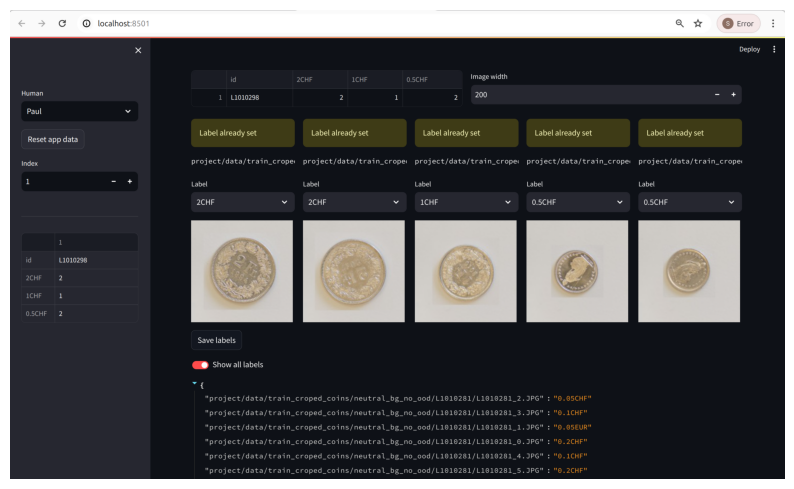

In [30]:
## Use the developed app to label the coins
# Laucmh the app with the follwoing script: 'streamlit run coin_labelling_app.py'

im = read_image('data/labeling_app_image.png')
fig, ax = plt.subplots(figsize=(10, 10))
plot_image(im)

### 3.2 Merge the manually labelled coins from each person into as single file

In [33]:
# Merge the labels
labels_1 = json.load(open('data/coin_train_labels_Paul.json'))
labels_2 = json.load(open('data/coin_train_labels_Marine.json'))
labels_3 = json.load(open('data/coin_train_labels_Seb.json'))
labels = {**labels_1, **labels_2, **labels_3}

# Save the labels
with open('data/coin_train_labels.json', 'w') as f:
    json.dump(labels, f, indent=4)

# 4. Classify the cropped coins

In [1]:
import numpy as np
import pandas as pd
import json
import cv2
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
import torchvision
import PIL
from torchvision.models import EfficientNet_V2_S_Weights
from torch import nn

### 4.1 Load the labeled data

In [36]:
labels_train_path = 'data/coin_train_labels.json'
labels_train = json.load(open(labels_train_path))
labels_train = pd.Series(labels_train).sort_index().to_frame('label').reset_index().rename(columns={'index': 'image_path'})

label_map = {label: i for i, label in enumerate(labels_train['label'].unique())}
# Save the label map
label_map_path = 'models/label_map.json'
with open(label_map_path, 'w') as f:
    json.dump(label_map, f)

print(label_map)
print("Number of classes:", len(label_map))
labels_train['label_id'] = labels_train['label'].map(label_map)

labels_train['image_path_trunc'] = labels_train['image_path'].apply(lambda x: "/".join(x.split('/')[1:]))
labels_train.head()

{'2CHF': 0, '2EUR': 1, '0.5CHF': 2, '0.5EUR': 3, '0.2EUR': 4, '0.1EUR': 5, '0.02EUR': 6, 'Not a coin': 7, '1CHF': 8, '5CHF': 9, '0.01EUR': 10, '0.05CHF': 11, '0.1CHF': 12, '0.2CHF': 13, '0.05EUR': 14, 'OOD': 15, '1EUR': 16}
Number of classes: 17


,image_path,label,label_id,image_path_trunc
0,project/data/train_croped_coins/hand/L1010373/...,2CHF,0,data/train_croped_coins/hand/L1010373/L1010373...
1,project/data/train_croped_coins/hand/L1010373/...,2EUR,1,data/train_croped_coins/hand/L1010373/L1010373...
2,project/data/train_croped_coins/hand/L1010373/...,0.5CHF,2,data/train_croped_coins/hand/L1010373/L1010373...
3,project/data/train_croped_coins/hand/L1010375/...,0.5EUR,3,data/train_croped_coins/hand/L1010375/L1010375...
4,project/data/train_croped_coins/hand/L1010375/...,0.2EUR,4,data/train_croped_coins/hand/L1010375/L1010375...


### 4.2 Format the data for training and perform data augmentation

For the classifier training, we will augment the data by applying simple transformations to the images. This will help the classifier to generalize better to new data.
The transformations we will apply are:
- **Rotation**: we will rotate the images by a random angle between -180 and 180 degrees
- **Jitter**: we will add a small amount of noise to the images

We split the data into a training and validation set with startified sampling to ensure that the classes are balanced in both sets.

In [50]:
class CoinDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.data.iloc[idx]
        image = PIL.Image.open(label['image_path_trunc'])
        if self.transform:
            image = self.transform(image)
        return image, label['label_id']

    def get_loader(self, batch_size, shuffle=True):
        return DataLoader(self, batch_size=batch_size, shuffle=shuffle)

train_transform = transforms.Compose([
    transforms.Resize(224),  # Resize to a smaller size for faster processing
    transforms.RandomRotation(180),  # Data augmentation
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.4, hue=0.3),
    transforms.ToTensor(),          # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

eval_transform = transforms.Compose([
    transforms.Resize(224),  # Resize to a smaller size for faster processing
    transforms.ToTensor(),          # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

train_data, val_data = train_test_split(labels_train, test_size=0.2, random_state=42, stratify=labels_train['label_id'])

train_dataset = CoinDataset(train_data, transform=train_transform)
val_dataset = CoinDataset(val_data, transform=eval_transform)

batch_size = 16
train_loader = train_dataset.get_loader(batch_size=batch_size, shuffle=False)
val_loader = val_dataset.get_loader(batch_size=batch_size, shuffle=False)
data_loaders = {'train': train_loader, 'val': val_loader}
data_sizes = {'train': len(train_data), 'val': len(val_data)}

### 4.3 Define the classification model

To classify the coins, we will use an efficientnet model. Efficientnet models are state-of-the-art models that are efficient and accurate. We will use the efficientnet-v2-s model, which is a small model that is suitable for this task.
We start from the pre-trained weights obtained from pre-training on the imagenet-1k dataset, which contains a large number of images from different classes. We will fine-tune the model on the coin dataset.

In [7]:
model = torchvision.models.efficientnet_v2_s(
    weights=EfficientNet_V2_S_Weights.IMAGENET1K_V1,
)
model.classifier = nn.Linear(1280, len(label_map))  # Change the output layer to match the number of classes

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 110MB/s]


### 4.4 Train the model

In [8]:
from coin_calssification_utils import train_model
device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

best_model_weights, acc_hist = train_model(
    model=model,
    dataloaders=data_loaders,
    dataset_sizes=data_sizes,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=30,
)

# Save the model for inference on the test set and evaluation
model_path = 'models/efficient_net_coin_classifier.pth'
torch.save(best_model_weights, model_path)
print('Model saved')

Epoch 0/29
----------


train epoch 0: 100%|██████████| 20/20 [04:12<00:00, 12.61s/it]


train Loss: 2.7503 Acc: 0.1741


val epoch 0: 100%|██████████| 5/5 [00:41<00:00,  8.37s/it]


val Loss: 2.6540 Acc: 0.3418
Epoch 1/29
----------


train epoch 1: 100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


train Loss: 2.3930 Acc: 0.4019


val epoch 1: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


val Loss: 2.0591 Acc: 0.5570
Epoch 2/29
----------


train epoch 2: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


train Loss: 1.7169 Acc: 0.6171


val epoch 2: 100%|██████████| 5/5 [00:01<00:00,  3.01it/s]


val Loss: 1.4312 Acc: 0.5823
Epoch 3/29
----------


train epoch 3: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


train Loss: 1.1588 Acc: 0.7184


val epoch 3: 100%|██████████| 5/5 [00:01<00:00,  3.12it/s]


val Loss: 0.9459 Acc: 0.7468
Epoch 4/29
----------


train epoch 4: 100%|██████████| 20/20 [00:13<00:00,  1.53it/s]


train Loss: 0.7820 Acc: 0.8165


val epoch 4: 100%|██████████| 5/5 [00:01<00:00,  3.10it/s]


val Loss: 0.6805 Acc: 0.8481
Epoch 5/29
----------


train epoch 5: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


train Loss: 0.5789 Acc: 0.8671


val epoch 5: 100%|██████████| 5/5 [00:01<00:00,  3.03it/s]


val Loss: 0.5258 Acc: 0.8861
Epoch 6/29
----------


train epoch 6: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


train Loss: 0.4249 Acc: 0.9051


val epoch 6: 100%|██████████| 5/5 [00:01<00:00,  2.91it/s]


val Loss: 0.5077 Acc: 0.8861
Epoch 7/29
----------


train epoch 7: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


train Loss: 0.3274 Acc: 0.9082


val epoch 7: 100%|██████████| 5/5 [00:01<00:00,  3.09it/s]


val Loss: 0.4876 Acc: 0.8861
Epoch 8/29
----------


train epoch 8: 100%|██████████| 20/20 [00:12<00:00,  1.66it/s]


train Loss: 0.2744 Acc: 0.9209


val epoch 8: 100%|██████████| 5/5 [00:01<00:00,  3.08it/s]


val Loss: 0.4136 Acc: 0.9114
Epoch 9/29
----------


train epoch 9: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


train Loss: 0.2396 Acc: 0.9462


val epoch 9: 100%|██████████| 5/5 [00:01<00:00,  3.05it/s]


val Loss: 0.4593 Acc: 0.9114
Epoch 10/29
----------


train epoch 10: 100%|██████████| 20/20 [00:12<00:00,  1.63it/s]


train Loss: 0.1846 Acc: 0.9620


val epoch 10: 100%|██████████| 5/5 [00:01<00:00,  2.83it/s]


val Loss: 0.4197 Acc: 0.9241
Epoch 11/29
----------


train epoch 11: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


train Loss: 0.1962 Acc: 0.9494


val epoch 11: 100%|██████████| 5/5 [00:01<00:00,  2.99it/s]


val Loss: 0.4831 Acc: 0.8861
Epoch 12/29
----------


train epoch 12: 100%|██████████| 20/20 [00:12<00:00,  1.65it/s]


train Loss: 0.1424 Acc: 0.9747


val epoch 12: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


val Loss: 0.4933 Acc: 0.8987
Epoch 13/29
----------


train epoch 13: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


train Loss: 0.1433 Acc: 0.9684


val epoch 13: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


val Loss: 0.4607 Acc: 0.8734
Epoch 14/29
----------


train epoch 14: 100%|██████████| 20/20 [00:11<00:00,  1.68it/s]


train Loss: 0.1095 Acc: 0.9747


val epoch 14: 100%|██████████| 5/5 [00:01<00:00,  3.11it/s]


val Loss: 0.4815 Acc: 0.9114
Epoch 15/29
----------


train epoch 15: 100%|██████████| 20/20 [00:12<00:00,  1.55it/s]


train Loss: 0.0841 Acc: 0.9905


val epoch 15: 100%|██████████| 5/5 [00:01<00:00,  2.88it/s]


val Loss: 0.3744 Acc: 0.9241
Epoch 16/29
----------


train epoch 16: 100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


train Loss: 0.1168 Acc: 0.9810


val epoch 16: 100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


val Loss: 0.3976 Acc: 0.9367
Epoch 17/29
----------


train epoch 17: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


train Loss: 0.0705 Acc: 0.9905


val epoch 17: 100%|██████████| 5/5 [00:02<00:00,  2.33it/s]


val Loss: 0.4544 Acc: 0.9114
Epoch 18/29
----------


train epoch 18: 100%|██████████| 20/20 [00:11<00:00,  1.73it/s]


train Loss: 0.1178 Acc: 0.9620


val epoch 18: 100%|██████████| 5/5 [00:02<00:00,  2.34it/s]


val Loss: 0.6464 Acc: 0.8861
Epoch 19/29
----------


train epoch 19: 100%|██████████| 20/20 [00:11<00:00,  1.79it/s]


train Loss: 0.1584 Acc: 0.9494


val epoch 19: 100%|██████████| 5/5 [00:02<00:00,  2.19it/s]


val Loss: 0.3827 Acc: 0.9494
Epoch 20/29
----------


train epoch 20: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


train Loss: 0.0742 Acc: 0.9842


val epoch 20: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s]


val Loss: 0.4311 Acc: 0.9241
Epoch 21/29
----------


train epoch 21: 100%|██████████| 20/20 [00:11<00:00,  1.74it/s]


train Loss: 0.0404 Acc: 1.0000


val epoch 21: 100%|██████████| 5/5 [00:02<00:00,  2.13it/s]


val Loss: 0.3965 Acc: 0.9494
Epoch 22/29
----------


train epoch 22: 100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


train Loss: 0.0467 Acc: 0.9937


val epoch 22: 100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


val Loss: 0.4613 Acc: 0.8987
Epoch 23/29
----------


train epoch 23: 100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


train Loss: 0.0519 Acc: 0.9905


val epoch 23: 100%|██████████| 5/5 [00:02<00:00,  2.05it/s]


val Loss: 0.3929 Acc: 0.9114
Epoch 24/29
----------


train epoch 24: 100%|██████████| 20/20 [00:11<00:00,  1.69it/s]


train Loss: 0.0542 Acc: 0.9905


val epoch 24: 100%|██████████| 5/5 [00:02<00:00,  2.06it/s]


val Loss: 0.3912 Acc: 0.9367
Epoch 25/29
----------


train epoch 25: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]


train Loss: 0.0581 Acc: 0.9810


val epoch 25: 100%|██████████| 5/5 [00:02<00:00,  2.11it/s]


val Loss: 0.4018 Acc: 0.9241
Epoch 26/29
----------


train epoch 26: 100%|██████████| 20/20 [00:12<00:00,  1.64it/s]


train Loss: 0.0546 Acc: 0.9747


val epoch 26: 100%|██████████| 5/5 [00:02<00:00,  1.78it/s]


val Loss: 0.6681 Acc: 0.8481
Epoch 27/29
----------


train epoch 27: 100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


train Loss: 0.0779 Acc: 0.9778


val epoch 27: 100%|██████████| 5/5 [00:02<00:00,  2.32it/s]


val Loss: 0.3845 Acc: 0.9367
Epoch 28/29
----------


train epoch 28: 100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


train Loss: 0.0723 Acc: 0.9842


val epoch 28: 100%|██████████| 5/5 [00:02<00:00,  2.49it/s]


val Loss: 0.4106 Acc: 0.9367
Epoch 29/29
----------


train epoch 29: 100%|██████████| 20/20 [00:11<00:00,  1.71it/s]


train Loss: 0.0890 Acc: 0.9747


val epoch 29: 100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


val Loss: 0.6208 Acc: 0.8987
Model saved


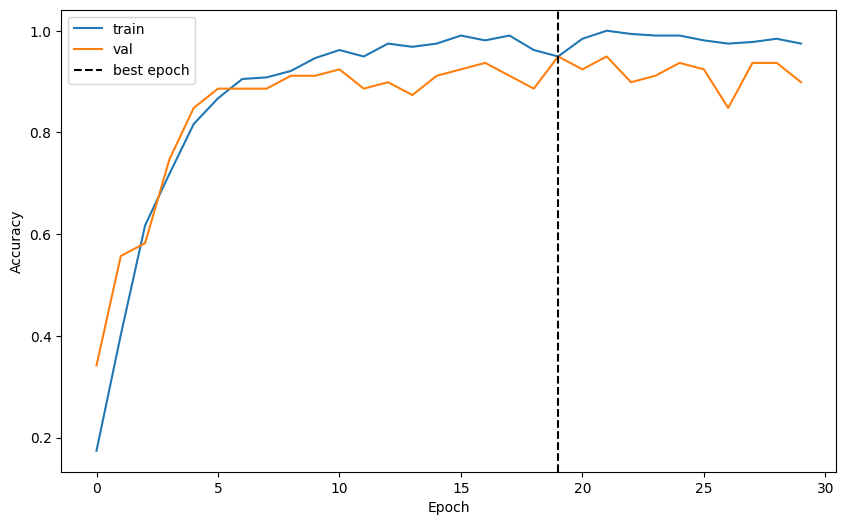

In [12]:
# Visualize the training progress and plot the best epoch

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(acc_hist['train'], label='train')
plt.plot(acc_hist['val'], label='val')

best_epoch = np.argmax(acc_hist['val'])
plt.axvline(best_epoch, color='black', linestyle='--', label='best epoch')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 4.5 Evaluate the model on the validation set

In [41]:
from coin_calssification_utils import get_model

# Load the model
model = get_model(num_classes=len(label_map))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_state_dict = torch.load('models_weights/efficient_net_coin_classifier.pth', map_location=device)
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [60]:
# Compute the accuracy on the validation set per class

model.eval()
model.to(device)

correct = 0
total = 0
class_correct = {label: 0 for label in label_map}
class_total = {label: 0 for label in label_map}
        
for images, labels in tqdm(val_loader, desc='Validation evaluation'):
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    for label, id in label_map.items():
        class_total[label] += (labels == id).sum().item()
        class_correct[label] += ((predicted == labels) & (labels == id)).sum().item()

Validation evaluation: 100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


In [57]:
print('Accuracy of the network on the validation set: %d %%' % (100 * correct / total))
class_accuracy = {label: 100 * class_correct[label] / class_total[label] for label in label_map}

class_acc_df = pd.Series(class_accuracy).sort_values(ascending=False)
label_counts = labels_train['label'].value_counts(normalize=True)

class_acc_df = pd.DataFrame({'accuracy': class_acc_df, 'class_proportion': label_counts})
class_acc_df['class_proportion'] = class_acc_df['class_proportion'].map(lambda x: f'{x:.2%}')
class_acc_df.sort_values('accuracy', ascending=False, inplace=True)
class_acc_df

Accuracy of the network on the validation set: 94 %


,accuracy,class_proportion
0.01EUR,100.0,4.55%
0.02EUR,100.0,5.88%
Not a coin,100.0,3.21%
5CHF,100.0,6.42%
2EUR,100.0,8.56%
2CHF,100.0,5.35%
1EUR,100.0,2.67%
0.5EUR,100.0,7.49%
OOD,100.0,13.10%
0.2EUR,100.0,7.75%


We observe that the model has a high accuracy on the validation set (94%), which indicates that it is able to generalize well to new data.
Even tough our classes are unballanced, we do not observe a performance drop on minority classes.
Hence we decided not to apply any class balancing techniques.